![download.png](download.png)


## Import Packages

In [2]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier
from sklearn.svm import SVC


# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# for feature selection
from sklearn.feature_selection import SelectFromModel

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [3]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [4]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

## Data Exploration 
*To choose which country to work on*

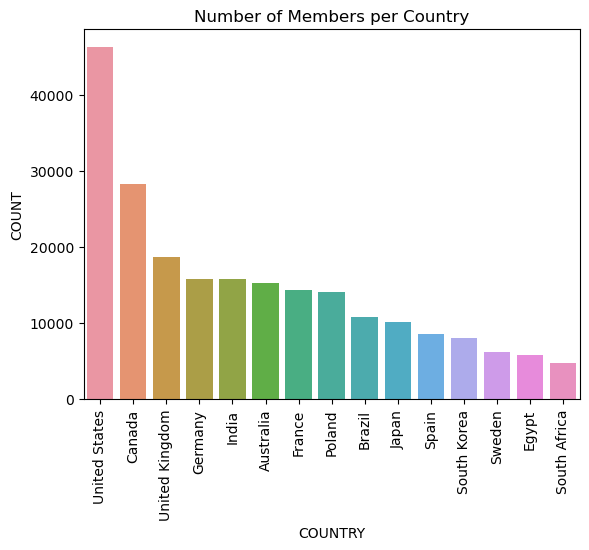

In [5]:
#Unique members
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

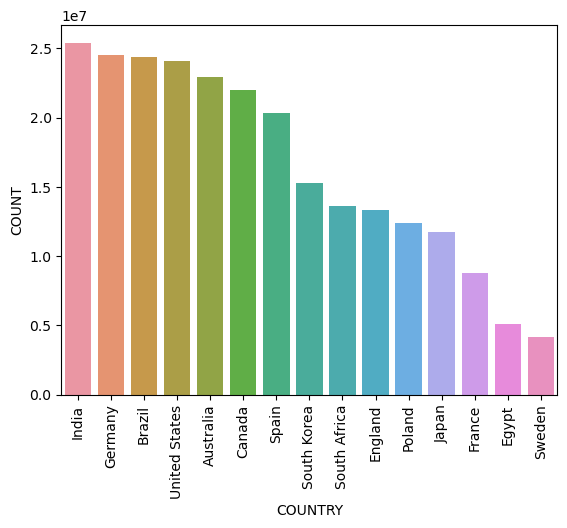

In [6]:
#Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [7]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)


#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]
df.show()

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"   |"PRI

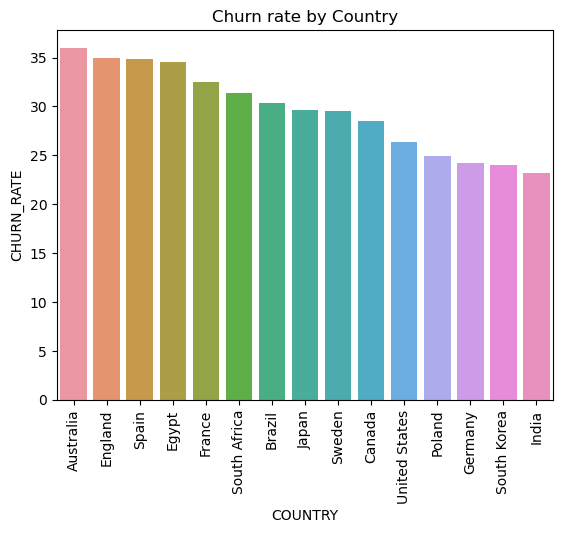

In [8]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

## Preparing the table for Modelling

In [9]:
#Filter to only Australia
filtered_country_customer_df=tasty_bytes_customer_loyalty.filter(F.col('COUNTRY')=='United States')

#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=filtered_country_customer_df,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [11]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"

In [12]:
#Total Quantity of each order
temp_df=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('QUANTITY')).alias('Total_Quantity'))

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

#Merge to get transactions table
combined_df=remove_dup.join(
    right=temp_df,
    on="ORDER_ID",
    how="inner"
)
combined_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"DATE"      |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_I

In [13]:
# assuming you have a DataFrame called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = combined_df.withColumn('rank', F.rank().over(window_spec))

#Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

#Get second max order of each customer
second_max_order_ts = orders_with_rank.filter(F.col('rank') == 2).select('customer_id', 'order_ts')


In [14]:
#Rename columns
second_max_order_ts = second_max_order_ts.withColumnRenamed('ORDER_TS','2ndMax_Order_TS')
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [15]:
#Merge with secon max order dataframe
temp_df=combined_df.join(right=second_max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = temp_df.filter(F.col('ORDER_TS') <= F.col('2ndMax_Order_TS'))

### Feature Engineering: Adding RFM Columns

In [16]:
#Display last purchase
tasty_bytes_orders_v.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



In [17]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

### Feature Engineering: Adding Average Time Difference, Max and Min Days without Purchase

In [18]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

#Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

### Feature Engineering Categorical Variables

In [19]:
#Get Customer demographic
cust_demo=filtered_country_customer_df.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

cust_demo.show()


------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"    |"AGE"  |
------------------------------------------------------------------------------
|118            |1988-06-13       |Male         |Single              |34     |
|189            |1984-03-05       |Undisclosed  |Married             |38     |
|204            |1979-06-25       |Male         |Undisclosed         |43     |
|42             |1966-06-28       |Undisclosed  |Single              |56     |
|59             |1961-06-05       |Male         |Married             |61     |
|65             |1958-09-01       |Male         |Divorced/Seperated  |64     |
|106            |1967-05-10       |Female       |Single              |55     |
|219            |1965-12-19       |Undisclosed  |Married             |57     |
|222            |1965-07-06       |Female       |Single              |57     |
|22             |1949-01-12       |Male         |Mar

In [20]:
#Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')

#Convert to pandas
final_df=final_df.to_pandas()

In [21]:
#Add Days To Next Order
final_df['Days_To_Next_Order']=(final_df['MAX_ORDER_TS']-final_df['ORDER_TS']).dt.days

In [22]:
# # get categorical data
# cat_df = temp_df.copy()
# cat_df = cat_df.drop(columns=['ORDER_ID','POSTAL_CODE','PREFERRED_LANGUAGE','SIGN_UP_DATE',
#                      'DATE','TRUCK_ID','ORDER_TS','ORDER_DETAIL_ID', 'LINE_NUMBER',
#                      'TRUCK_BRAND_NAME', 'MENU_TYPE', 'PRIMARY_CITY', 'REGION', 'COUNTRY',
#                      'FRANCHISE_FLAG', 'FRANCHISE_ID', 'FRANCHISEE_FIRST_NAME', 'FRANCHISEE_LAST_NAME',
#                      'LOCATION_ID','FRANCHISEE_FIRST_NAME','FRANCHISEE_LAST_NAME','LOCATION_ID','PLACEKEY',
#                      'LOCATION_NAME','TOP_CATEGORY','SUB_CATEGORY','LATITUDE','LONGITUDE','FIRST_NAME',
#                      'LAST_NAME','E_MAIL','PHONE_NUMBER','CHILDREN_COUNT','MENU_ITEM_ID','MENU_ITEM_NAME',
#                      'QUANTITY','UNIT_PRICE','PRICE','ORDER_AMOUNT','ORDER_TAX_AMOUNT',
#                      'ORDER_DISCOUNT_AMOUNT', 'ORDER_TOTAL','TOTAL_QUANTITY','2ndMax_Order_TS','CITY','time_diff'])

# final_df = final_df.merge(right=cat_df,how='left',on='CUSTOMER_ID')

# # get max date/latest date in the ORDER_TS column
# latest_date = pd.Timestamp('2022-11-01 00:00:00')

# final_df["BIRTHDAY_DATE"] = final_df["BIRTHDAY_DATE"].apply(pd.to_datetime)

# final_df["AGE"] = ((latest_date - final_df["BIRTHDAY_DATE"])/np.timedelta64(1,'Y'))

# final_df["AGE"] = final_df["AGE"].round()
# final_df['FAVOURITE_BRAND'] = final_df['FAVOURITE_BRAND'].fillna("Undisclosed")
# final_df['GENDER'] = final_df['GENDER'].fillna("Undisclosed")
# final_df['MARITAL_STATUS'] = final_df['MARITAL_STATUS'].fillna("Undisclosed")

# final_df["FAVOURITE_BRAND"] = final_df["FAVOURITE_BRAND"].astype('category')
# final_df["GENDER"] = final_df["GENDER"].astype('category')
# final_df["MARITAL_STATUS"] = final_df["MARITAL_STATUS"].astype('category')

# final_df["FAVOURITE_BRAND_encode"] = final_df["FAVOURITE_BRAND"].cat.codes
# final_df["GENDER_encode"] = final_df["GENDER"].cat.codes
# final_df["MARITAL_STATUS_encode"] = final_df["MARITAL_STATUS"].cat.codes

# from feature_engine.encoding import OneHotEncoder

# ohe_enc = OneHotEncoder(
#     top_categories=None,
#     drop_last=True)  # to return k-1, false to return k

# ohe_enc.fit(final_df)

# final_df = ohe_enc.transform(final_df)

### Outlier Handling

In [23]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns.drop('CUSTOMER_ID')

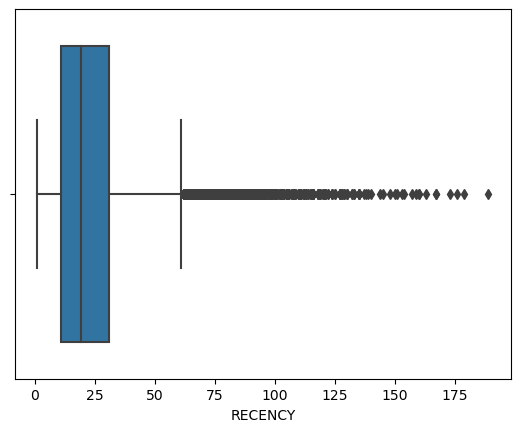

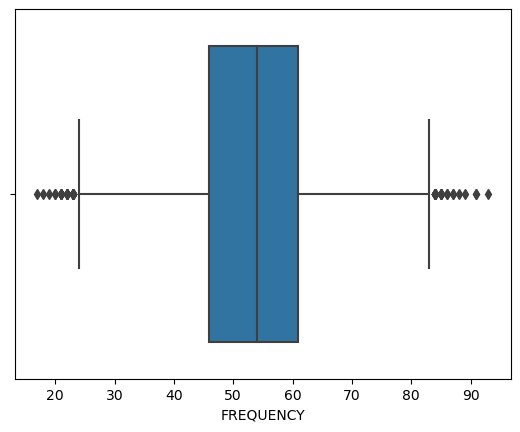

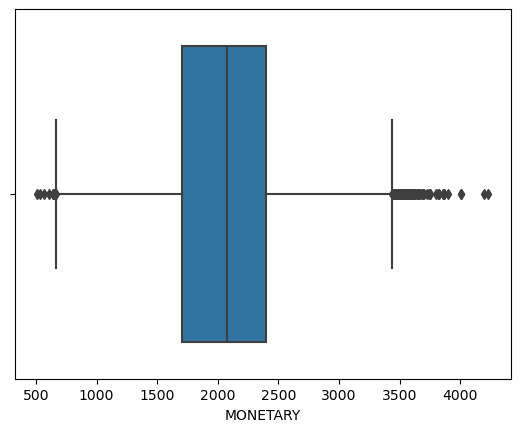

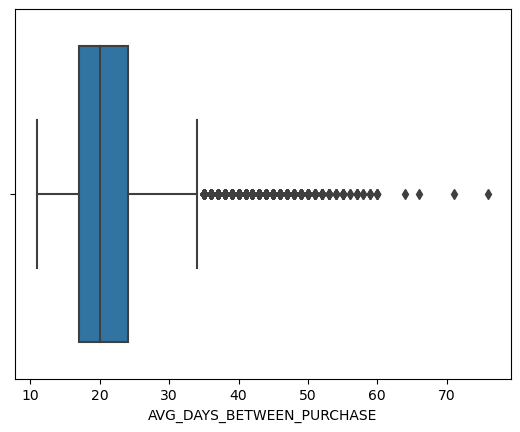

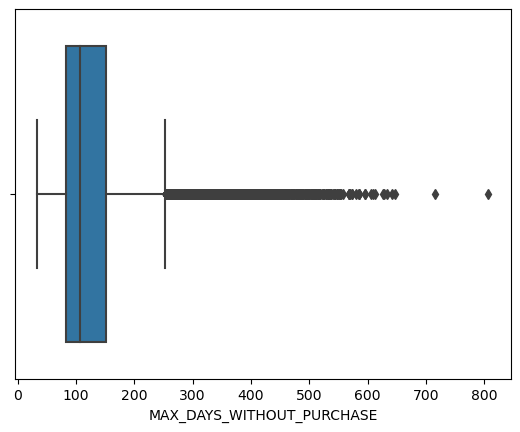

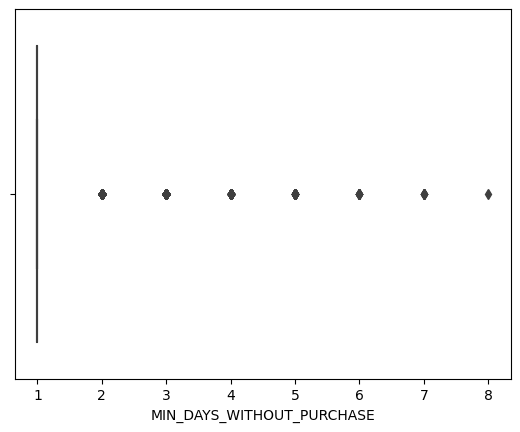

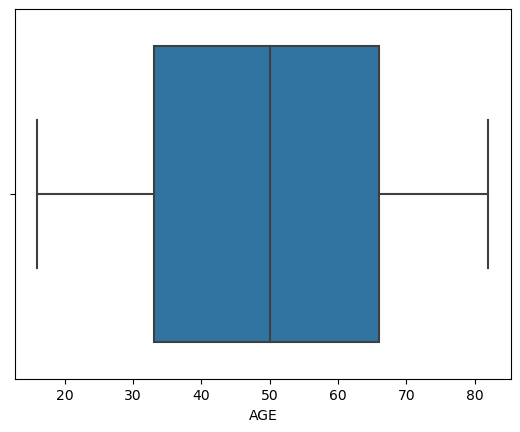

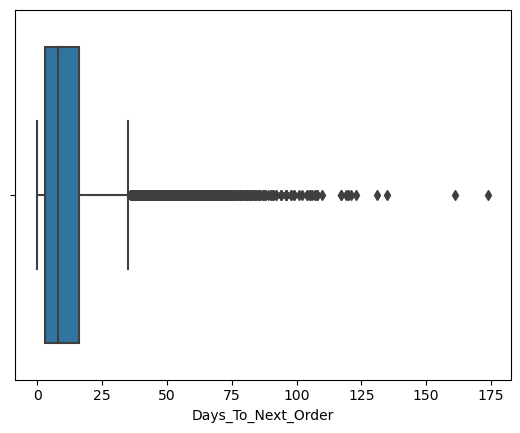

In [25]:
for i in num_cols:
    sns.boxplot(data=final_df,x=final_df[i])
    plt.show()

In [26]:
from feature_engine.outliers import Winsorizer
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

*Note there is no point dealing with outliers in Days to next order as even when dealt with, the 50% mark stays the same, meaning no change to our target variable.

In [27]:
final_df_win = windsorizer.transform(final_df)

In [28]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','RECENCY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'RECENCY'])

In [29]:
final_df_win = windsorizer.transform(final_df_win)


### One Hot Encoding

In [30]:
#One Hot Encoding
ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

ohe_enc.fit(final_df_win)
final_df_enc = ohe_enc.transform(final_df_win)


### Final Table

In [68]:
#Describe the target
final_df_enc['Days_To_Next_Order'].describe()

count    46300.000000
mean        12.073758
std         12.849471
min          0.000000
25%          3.000000
50%          8.000000
75%         16.000000
max        174.000000
Name: Days_To_Next_Order, dtype: float64

In [70]:
#Add Target Variable Next Purchase Day Range 
final_df_enc['NextPurchaseDayRange'] = 1
final_df_enc.loc[final_df_enc['Days_To_Next_Order']<=8,'NextPurchaseDayRange'] = 0

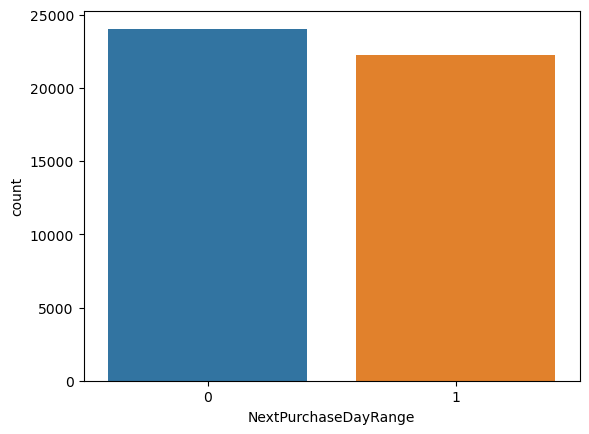

In [71]:
#Distribution of target variable
sns.countplot(data=final_df_enc,x='NextPurchaseDayRange')
plt.show()

### Train Test Split

In [121]:
df1=final_df_enc[final_df_enc['NextPurchaseDayRange']==1]
len(df1)

22246

In [122]:
df0=final_df_enc[final_df_enc['NextPurchaseDayRange']==0]
len(df0)

24054

In [123]:
#Perform Stratified Sampling
df0_sampled = df0.sample(n=len(df1), random_state=4).copy()
df_new=pd.concat([df1,df0_sampled],axis=0)
df_new['NextPurchaseDayRange'].value_counts()

1    22246
0    22246
Name: NextPurchaseDayRange, dtype: int64

In [143]:
X = df_new.drop(['Days_To_Next_Order','MAX_ORDER_TS','ORDER_TS','FAVOURITE_BRAND_encode','GENDER_encode','MARITAL_STATUS_encode','BIRTHDAY_DATE'], axis =1,
                  errors='ignore')
y = df_new["NextPurchaseDayRange"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=4)

In [144]:
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=4)

In [145]:
#Save tables to 
session.create_dataframe(X_train).write.save_as_table(table_name="train_table", mode='overwrite')
session.create_dataframe(X_test).write.save_as_table(table_name="test_table", mode='overwrite')
session.create_dataframe(X_holdout).write.save_as_table(table_name="holdout_table", mode='overwrite')

In [147]:
X_train=X_train.drop('NextPurchaseDayRange',axis=1)
X_test=X_test.drop('NextPurchaseDayRange',axis=1)
X_holdout=X_holdout.drop('NextPurchaseDayRange',axis=1)

### Feature Scaling

In [130]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

#transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_holdout_scaled=scaler.transform(X_holdout)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_houldout_scaled=pd.DataFrame(X_holdout_scaled,columns=X_holdout.columns)

## Model Building

## Define Evaluation Function

In [131]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\nHoldout Accuracy:',model.score(X_holdout, y_holdout))

In [132]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModelWithName(model,model_name):
    print(model_name)
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\n')

## Models

### Logistic Regression

#### Build the model

In [82]:
#Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 0.7440964722822174 
Test Accuracy: 0.7482721382289417 
Holdout Accuracy: 0.7470842332613391


In [ ]:
#After scaling
#Train Accuracy: 0.7466522678185745 
#Test Accuracy: 0.739812814974802

In [ ]:
#After outlier handling and scaling
#Train Accuracy: 0.7076519592718297 
#Test Accuracy: 0.703959683225342

In [ ]:
#Before outlier handling
#Train Accuracy: 0.7485035482875656 
#Test Accuracy: 0.7405327573794096

#### Improve the model

In [48]:
# Task 1: Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

c:\Anaconda\envs\py38_env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py38_env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Anaconda\envs\py38_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Anaconda\envs\py38_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(


0.7448524118070554
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [49]:
#Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

Train Accuracy: 0.7451403887688985 
Test Accuracy: 0.7437365010799136 
Holdout Accuracy: 0.7441684665226782


## Decision Tree

#### Build the model

In [50]:
#Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 0.9178905687544996 
Test Accuracy: 0.713390928725702 
Holdout Accuracy: 0.7113390928725702


#### Improve the model

In [51]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_params_)

0.7684305255579553
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 100, 'min_samples_split': 2}


In [52]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 0.7690424766018719 
Test Accuracy: 0.7653347732181426 
Holdout Accuracy: 0.7732181425485961


### MLP

#### Build the model

In [53]:
#Build MLP model
MLP_before = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)

MLP_before.fit(X_train, y_train)

evaluateModel(MLP_before)

Train Accuracy: 0.7533837293016559 
Test Accuracy: 0.7549676025917926 
Holdout Accuracy: 0.7561555075593952


#### Improve the model

In [55]:
# mlp = MLPClassifier(hidden_layer_sizes = (10,), max_iter = 2000, random_state=2)
# param_grid = {"activation": ["logistic", "relu"],
#              "hidden_layer_sizes" : [(5,), (10,), (20)],
#              "max_iter": [200, 2000, 4000],
#              "solver" : ["sgd", "adam"]}

# gs =GridSearchCV(mlp, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
# gs = gs.fit(X_train, y_train)

# print(gs.best_score_)
# print(gs.best_params_)
# ''''{'activation': 'relu',
#  'hidden_layer_sizes': 20,
#  'max_iter': 2000,
#  'solver': 'adam'}'''

In [56]:
# # Create the ann model
# MLP_improved = MLPClassifier(**gs.best_params_)
# # Fit the model to the training set
# MLP_improved.fit(X_train,y_train)

# evaluateModel(MLP_improved)

### Random Forest

#### Build the model

In [57]:
#Build Random Forest Model

random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 1.0 
Test Accuracy: 0.7585313174946005 
Holdout Accuracy: 0.7682505399568035


#### Improve the model

In [58]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [1, 10, 50, 100],
'max_depth': [2, 4, 6, 8, 10],
'min_samples_split': [2, 5, 10, 15, 20]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7682505399568035
{'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 100}


In [59]:
#Task 1: Build Random Forest Model and Evaluate both training and testing accuracy
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 0.7754499640028798 
Test Accuracy: 0.7647948164146868 
Holdout Accuracy: 0.7721382289416847


In [60]:
#Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 1.0 
Test Accuracy: 0.6795896328293737 
Holdout Accuracy: 0.6803455723542117


In [61]:
adb = AdaBoostClassifier()

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7690424766018717
{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


In [62]:
#Task 2: Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

Train Accuracy: 0.7690424766018719 
Test Accuracy: 0.7653347732181426 
Holdout Accuracy: 0.7732181425485961


## XGboost

In [133]:
#Build XGBoost Model
xgb_before = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#Evaluate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 0.972128568217577 
Test Accuracy: 0.7491759065028468 
Holdout Accuracy: 0.7499250824093497


In [ ]:
Train Accuracy: 0.966997565087095 
Test Accuracy: 0.7539896605978872 
Holdout Accuracy: 0.7532307000786606

In [ ]:
Train Accuracy: 0.966997565087095 
Test Accuracy: 0.7539896605978872 
Holdout Accuracy: 0.7532307000786606

In [134]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [4, 6, 8], 
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [20, 50, 100, 200],
    'objective': ['binary:logistic'],
    'n_jobs': [-1]
}

gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7725901575685632
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 20, 'n_jobs': -1, 'objective': 'binary:logistic'}


In [135]:
# Task 3: Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(**gs.best_params_)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 0.7742189256012587 
Test Accuracy: 0.7698531615223254 
Holdout Accuracy: 0.7761462391369494


In [ ]:
Train Accuracy: 0.7700143988480922 
Test Accuracy: 0.7660907127429806 
Holdout Accuracy: 0.7739740820734341

In [ ]:
Train Accuracy: 0.7740026222138977 
Test Accuracy: 0.7768037761294673 
Holdout Accuracy: 0.7705360152826161

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test,xgb_improved.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      4816
           1       0.72      0.85      0.78      4444

    accuracy                           0.77      9260
   macro avg       0.77      0.77      0.77      9260
weighted avg       0.78      0.77      0.77      9260



In [ ]:
           precision    recall  f1-score   support

           0       0.83      0.69      0.75      4834
           1       0.71      0.85      0.77      4426

    accuracy                           0.76      9260
   macro avg       0.77      0.77      0.76      9260
weighted avg       0.78      0.76      0.76      9260

### Support Vector Classifier

#### Build the Model

In [ ]:
# # Task 4: Build SVM Model and Evaluate both training and testing accuracy 

# # Build model
# svc_before = SVC(kernel='linear', C=1)
# svc_before.fit(X_train,y_train)

# evaluateModel(svc_before)

#### Improve the Model

# Model Evaulation

In [ ]:
evaluateModelWithName(log_ref_before,'log_ref_before')
evaluateModelWithName(log_ref_improved,'log_ref_improved')

evaluateModelWithName(decision_tree_before,'decision_tree_before')
evaluateModelWithName(decision_tree_improved,'decision_tree_improved')

evaluateModelWithName(MLP_before,'MLP_before')
evaluateModelWithName(MLP_improved,'MLP_improved')

evaluateModelWithName(adb_before,'adb_before')
evaluateModelWithName(adb_improved,'adb_improved')

evaluateModelWithName(log_ref_before,'log_ref_before')
evaluateModelWithName(log_ref_before,'log_ref_before')

evaluateModelWithName(xgb_before,'xgb_before')
evaluateModelWithName(xgb_improved,'xgb_improved')

# evaluateModelWithName(svc_before,'svc_before')
# evaluateModelWithName(svc_improved,'svc_improved')

In [ ]:
xgb_final=xgb_before

# Data evaluation

In [ ]:
#Check top 10 features based on feature importance
ft_weights_xgb_clf = pd.DataFrame(xgb_improved.feature_importances_, columns=['is_promoted'], index=X_train.columns)
ft_weights_xgb_clf.sort_values('is_promoted', ascending=False, inplace=True)
ft_weights_xgb_clf.tail(100)

,is_promoted
RECENCY,0.881421
FREQUENCY,0.020584
MAX_DAYS_WITHOUT_PURCHASE,0.018658
AVG_DAYS_BETWEEN_PURCHASE,0.018232
MARITAL_STATUS_Married,0.013431
MARITAL_STATUS_Single,0.013178
AGE,0.012823
MONETARY,0.012073
CUSTOMER_ID,0.009600
MIN_DAYS_WITHOUT_PURCHASE,0.000000


In [ ]:
thresholds = np.sort(xgb_improved.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_improved, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train.to_numpy())
    # train model
    selection_model = XGBClassifier(**gs.best_params_)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test.to_numpy())
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=13, Accuracy: 76.50%
Thresh=0.000, n=13, Accuracy: 76.50%
Thresh=0.000, n=13, Accuracy: 76.50%
Thresh=0.000, n=13, Accuracy: 76.50%
Thresh=0.010, n=9, Accuracy: 76.49%
Thresh=0.012, n=8, Accuracy: 76.42%
Thresh=0.013, n=7, Accuracy: 76.52%
Thresh=0.013, n=6, Accuracy: 76.52%
Thresh=0.013, n=5, Accuracy: 76.52%
Thresh=0.018, n=4, Accuracy: 76.55%
Thresh=0.019, n=3, Accuracy: 76.46%
Thresh=0.021, n=2, Accuracy: 76.54%
Thresh=0.881, n=1, Accuracy: 76.47%


## Reset

In [ ]:
"""# Drop training table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()"""